# 3주차 Multilayer perceptron

<img src='https://d2l.ai/_images/mlp.svg'>




## 3.1 Activation function

In [1]:
!pip install --quiet d2l


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

### a. ReLU

현재까지 널리 사용되면서, 적용하기 쉬운 비선형 활성화 함수 *rectified linear unit* **(ReLU)** 함수를 그려봅시다.


$$ \texttt{ReLU}(x)=\max\{x, 0\} $$



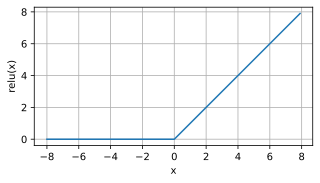

In [10]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))


ReLU 함수의 미분꼴은 *heavyside function* 입니다.

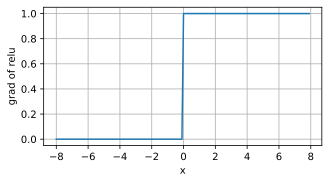

In [11]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

* ReLU 함수를 직접 구현해봅시다!

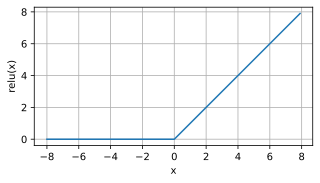

In [12]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.max(torch.zeros_like(x), x)

d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

In [13]:
# Clear out previous gradients
x.grad.data.zero_()


AttributeError: 'NoneType' object has no attribute 'data'

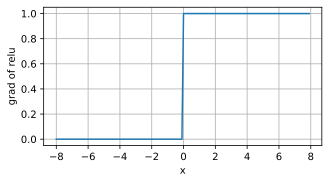

In [14]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

### b. Sigmoid

Sigmoid 함수는 실수 전체 $\mathbb{R}$ 도메인을 $(0, 1)$ 구간으로 맵핑하는 함수입니다.

$$ \texttt{Sigmoid}(x)={1\over 1+\exp(-x)}  $$


기울기 기반 학습 과정에서 sigmoid 는 부드럽고 미분가능한 좋은 성질을 가진 함수입니다.

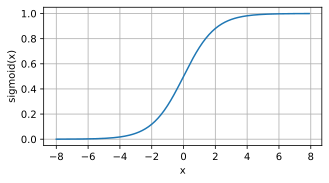

In [17]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

한편 sigmoid 함수의 미분은 다시 자기자신을 이용한 형태로 나타납니다.

$$ {d\over dx}\texttt{sigmoid}(x)={\exp(-x)\over(1+\exp(-x))^2}=\texttt{sigmoid}(x)(1-\texttt{sigmoid}(x)). $$

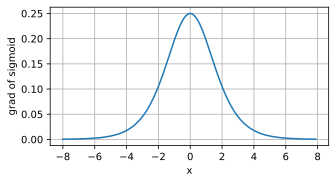

In [18]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

* Sigmoid 함수를 직접 구현해봅시다!

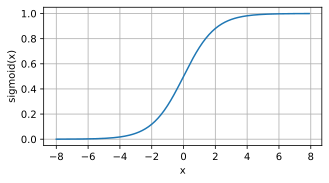

In [19]:
y = torch.sigmoid(x)

d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

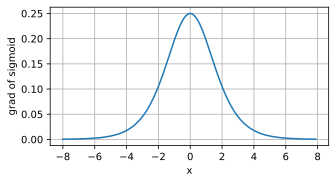

In [20]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

## 3.2 MLP implementation



In [21]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer ##, load_digits, load_wine ##

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Step 1. Load dataset

In [22]:
data = load_breast_cancer()

In [23]:
input = data.data
output = data.target

* GPU 사용이 가능하다면 device 를 GPU 로 설정!

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

* 데이터를 미리 설정한 device 로 이동합니다.

In [25]:
## Split datasets
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

## Retrieve length of the inputs
x_len = len(x_train[0])
y_len = len(y_train.unique())

In [26]:
print(x_train[0])
print(y_train[0])

tensor([1.1620e+01, 1.8180e+01, 7.6380e+01, 4.0880e+02, 1.1750e-01, 1.4830e-01,
        1.0200e-01, 5.5640e-02, 1.9570e-01, 7.2550e-02, 4.1010e-01, 1.7400e+00,
        3.0270e+00, 2.7850e+01, 1.4590e-02, 3.2060e-02, 4.9610e-02, 1.8410e-02,
        1.8070e-02, 5.2170e-03, 1.3360e+01, 2.5400e+01, 8.8140e+01, 5.2810e+02,
        1.7800e-01, 2.8780e-01, 3.1860e-01, 1.4160e-01, 2.6600e-01, 9.2700e-02])
tensor(1)


## Step 2 : CustomDataset 과 DataLoader

In [27]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [28]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size)

## Step 3 : Define "Model"

* activation function 이용

  * nn.Sigmoid()
  * nn.ReLU()
  * nn.tanH()


* batch normazliation 1d 란?
  * 파라미터 값으로 vector의 길이를 전해줌



* a. 직접 nn.Sequential() 로 구현하기

In [29]:
# input_layer에 들어가는 최초의 input 크기를 맞춰주자!
# output_layer로 출력되는 마지막 output 의 크기도 마찬가지.

model = nn.Sequential(
          nn.Linear(x_len ,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398, 15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15, y_len, bias=True),
          nn.Softmax()
          ).to(device)

* b. 파이썬 Class 로 구현하기

In [30]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(x_len ,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(398, 15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, y_len, bias=True), # hidden_layer3 = 10, output_layer = 2
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

* Weight initialization

In [31]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [32]:
model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)


/var/folders/_n/fwh4j7y91dg3vf42xy57zpd00000gn/T/ipykernel_47668/2561401709.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


## Step 4 : Loss function 과 Optimizer

* 다양한 optimizer 가 존재
  * https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조

In [33]:
loss_fn  = nn.CrossEntropyLoss().to(device)

In [34]:
optimizer = optim.Adam(model.parameters(), lr= 0.01)

## Step 5: Train Model

In [35]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 0.6551404595375061
10 0.504268229007721
20 0.4201711416244507
30 0.3988976776599884
40 0.39046400785446167
50 0.3827596604824066
60 0.3758704662322998
70 0.38843539357185364
80 0.3710639178752899
90 0.3863260746002197


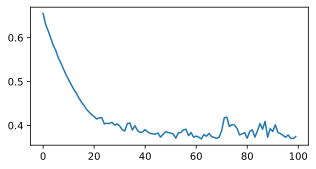

In [36]:
plt.plot(losses)
plt.show()

In [37]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [38]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.00381215 0.99618787]
argmax를 한 후의 output은 1
accuracy는 0.9298245614035088


# MLP 를 다뤄봅시다!

위 코드를 참고하여 직접 MLP 를 구현해봅시다.

load_digits() 또는 load_wine() 중 하나를 골라 시도해보세요!

- lr, optimizer, hidden layer(depth), neuron 수(width)를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!

In [42]:
from sklearn.datasets import load_digits

In [43]:
data = load_digits()
input = data.data
output = data.target

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [45]:
## Split datasets
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

## Retrieve length of the inputs
x_len = len(x_train[0])
y_len = len(y_train.unique())

In [47]:
print(x_train[0])
print(y_train[0])
print('x_len :', x_len)
print('y_len :', y_len)

tensor([ 0.,  0.,  0., 16., 12.,  1.,  0.,  0.,  0.,  0.,  6., 16., 14.,  7.,
         0.,  0.,  0.,  0., 14., 15.,  1., 11.,  0.,  0.,  0.,  0., 16., 15.,
         0., 14.,  1.,  0.,  0.,  1., 16., 10.,  0., 14.,  2.,  0.,  0.,  0.,
        15., 13.,  3., 15.,  3.,  0.,  0.,  0.,  9., 16., 16., 15.,  0.,  0.,
         0.,  0.,  0., 13., 16.,  8.,  0.,  0.])
tensor(0)
x_len : 64
y_len : 10


In [48]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [49]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size)

In [53]:
# input_layer에 들어가는 최초의 input 크기를 맞춰주자!
# output_layer로 출력되는 마지막 output 의 크기도 마찬가지.

model = nn.Sequential(
          nn.Linear(x_len ,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398, 15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15, y_len, bias=True),
          nn.Softmax()
          ).to(device)

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)
        
model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


/var/folders/_n/fwh4j7y91dg3vf42xy57zpd00000gn/T/ipykernel_47668/3858905627.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [54]:
loss_fn  = nn.CrossEntropyLoss().to(device)

In [61]:
optimizer = optim.Adam(model.parameters(), lr= 0.001)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 1.5630401372909546
10 1.5591301918029785
20 1.5554313659667969
30 1.5519046783447266
40 1.5485358238220215
50 1.5453370809555054
60 1.5422935485839844
70 1.5393928289413452
80 1.5366405248641968
90 1.5340298414230347


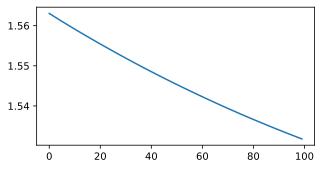

In [62]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())


plt.plot(losses)
plt.show()

In [63]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))


### 1. 64 - 398 - 15 - 10 / lr : 0.01 / optimizer : Adam / hidden layer(depth) : 3

In [60]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [3.0018755e-03 8.9408129e-01 1.7758343e-02 1.9940984e-04 7.2279130e-03
 1.1037003e-03 2.6819495e-02 3.8537235e-04 4.8835143e-02 5.8753754e-04]
argmax를 한 후의 output은 1
accuracy는 0.9814814814814815


### 2. 64 - 398 - 15 - 10 / lr : 0.01 / optimizer : RMSprop / hidden layer(depth) : 3

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 1.4668524265289307
10 1.4860128164291382
20 1.469690203666687
30 1.4654014110565186
40 1.4648109674453735
50 1.4646114110946655
60 1.4638001918792725
70 1.4635347127914429
80 1.4634147882461548
90 1.463309645652771


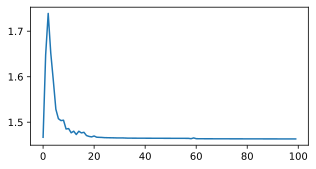

model의 output은 :  [6.8432287e-06 9.9816787e-01 4.5711393e-04 1.4306009e-07 6.9043665e-05
 2.2090876e-06 2.4184209e-04 2.1762547e-07 1.0526222e-03 1.9872775e-06]
argmax를 한 후의 output은 1
accuracy는 0.9666666666666667


In [68]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)


loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(model.parameters(), lr= 0.01)

losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())


plt.plot(losses)
plt.show()

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')


### 3. 64 - 398 - 15 - 10 / lr : 0.01 / optimizer : SGD / hidden layer(depth) : 3

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 1.4632152318954468
10 1.4632152318954468
20 1.4632152318954468
30 1.4632152318954468
40 1.4632152318954468
50 1.4632152318954468
60 1.4632152318954468
70 1.4632152318954468
80 1.4632152318954468
90 1.4632149934768677


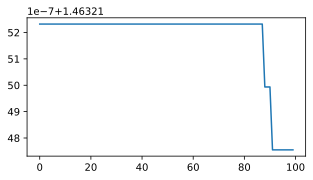

model의 output은 :  [6.8412942e-06 9.9816835e-01 4.5704725e-04 1.4302891e-07 6.9027177e-05
 2.2082925e-06 2.4177901e-04 2.1755109e-07 1.0523035e-03 1.9866018e-06]
argmax를 한 후의 output은 1
accuracy는 0.9666666666666667


In [69]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)


loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr= 0.01)

losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())


plt.plot(losses)
plt.show()

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))


print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')


### 4. 64 - 100 - 15 - 10 / lr : 0.01 / optimizer : Adam / hidden layer(depth) : 3

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 2.3031423091888428
10 2.2170064449310303
20 2.077361822128296
30 1.9417164325714111
40 1.8081597089767456
50 1.6895614862442017
60 1.6119976043701172
70 1.5608012676239014
80 1.5291420221328735
90 1.5111950635910034


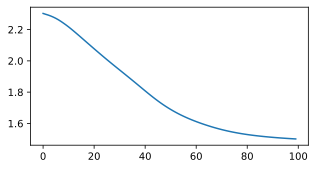

model의 output은 :  [4.7120338e-05 9.6792608e-01 1.0686778e-04 1.4226573e-03 1.5704384e-03
 3.6270651e-03 2.8682898e-03 5.2709430e-03 1.4102379e-02 3.0581569e-03]
argmax를 한 후의 output은 1
accuracy는 0.9648148148148148


In [71]:
# input_layer에 들어가는 최초의 input 크기를 맞춰주자!
# output_layer로 출력되는 마지막 output 의 크기도 마찬가지.

model = nn.Sequential(
          nn.Linear(x_len , 100, bias=True),
          nn.Sigmoid(),
          nn.Linear(100, 15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15, y_len, bias=True),
          nn.Softmax()
          ).to(device)

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)
        

loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.01)

losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())


plt.plot(losses)
plt.show()

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')


### 4. 64 - 100 - 80 - 40 - 10 / lr : 0.01 / optimizer : Adam / hidden layer(depth) : 4

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 2.302997350692749
10 2.1893506050109863
20 1.9450994729995728
30 1.7416244745254517
40 1.6457784175872803
50 1.5958436727523804
60 1.5720102787017822
70 1.5641257762908936
80 1.5609289407730103
90 1.5592210292816162


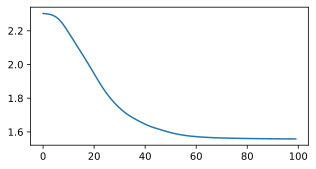

model의 output은 :  [1.0608499e-07 9.9690682e-01 1.4874577e-03 1.8383791e-04 3.7993887e-04
 1.7957295e-06 3.9582024e-04 6.4327486e-04 8.5482208e-07 1.5269218e-07]
argmax를 한 후의 output은 1
accuracy는 0.8814814814814815


In [75]:
# input_layer에 들어가는 최초의 input 크기를 맞춰주자!
# output_layer로 출력되는 마지막 output 의 크기도 마찬가지.

model = nn.Sequential(
          nn.Linear(x_len , 100, bias=True),
          nn.Sigmoid(),
          nn.Linear(100, 80, bias=True),
          nn.Sigmoid(),
          nn.Linear(80, 40, bias=True),
          nn.Sigmoid(),
          nn.Linear(40, y_len, bias=True),
          nn.Softmax()
          ).to(device)

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)
        

loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.01)

losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())


plt.plot(losses)
plt.show()

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')


많은 분석을 진행하지는 못했지만 1번이 가장 결과가 좋았음.